# Hopfield Network Model

Author: Alisia Sara Baielli

Date: 27/05/2024

### Introduction

The Hopfield network is a type of recurrent artificial neural network that functions as a content-addressable memory system with binary threshold nodes. Introduced by John Hopfield in 1982, it has become a foundational model for studying associative memory in neural networks.

### Problem Description

This project aims to simulate the Hopfield network as described in the paper "Neural networks and physical systems with emergent collective computational abilities" by John Hopfield. The primary objective is to investigate the probability of retrieving a stored pattern as the number of stored patterns varies at finite temperature. This will be achieved using both the Metropolis and heat-bath algorithms to update neuron states. The network's error correction capabilities and performance under different conditions, such as high memory load and noisy inputs, will also be examined.

By implementing these principles, the simulation will demonstrate how the network's retrieval success rate is influenced by different parameters, including the number of stored patterns, temperature, and noise level. The results will provide insights into the practical capabilities and limitations of the Hopfield network in associative memory tasks.

# 1. Hopfield Network Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class HopfieldNetwork:
    def __init__(self, num_neurons):
        # Initialize the network with the number of neurons
        self.N = num_neurons
        self.neurons = np.ones(self.N, dtype=np.float64)  
        self.weights = np.zeros((self.N, self.N), dtype=np.float64)  

    def store_patterns(self, patterns):
        # Store the given patterns in the network by updating the weight matrix according to Hebbian learning rules
        self.weights = np.sum([np.outer(p, p) for p in patterns], axis=0, dtype=np.float64) 
        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)  
 
    def update_neuron_heatbath(self, i, temp):
        # Update the state of neuron 'i' using the Heat-bath algorithm
        h = np.dot(self.weights[i], self.neurons)
        p = 1 / (1 + np.exp(-2 * h / temp))
        self.neurons[i] = 1 if np.random.rand() < p else -1

    def update_neuron_metropolis(self, i, temp):
        # Update the state of neuron 'i' using the Metropolis algorithm
        h = np.dot(self.weights[i], self.neurons)
        current_energy = -h * self.neurons[i]
        proposed_energy = -h * (-self.neurons[i])
        delta_e = proposed_energy - current_energy
        if delta_e < 0 or np.random.rand() < np.exp(-delta_e / temp):
            self.neurons[i] = -self.neurons[i]

    def recall_pattern(self, pattern, temp, steps=100, algorithm='heatbath'):
        # Recall a stored pattern by iteratively updating the network state
        self.neurons = np.copy(pattern)
        for _ in range(steps):
            i = np.random.randint(self.N)
            if algorithm == 'heatbath':
                self.update_neuron_heatbath(i, temp)
            else:
                self.update_neuron_metropolis(i, temp)
        return self.neurons

    def compute_error(self, original):
        # Compute the error between the recalled pattern and the original pattern
        return np.sum(original != self.neurons) / self.N

In [3]:
# Parameters
N = 100
temperatures = [0.1, 0.7, 1, 3, 7, 10]
num_patterns_list = [5, 10, 15, 20, 30, 50, 70]
num_trials = 100
steps = 100
algorithms = ['heatbath', 'metropolis']

## 1.1 Probability of Successful Retrieval 

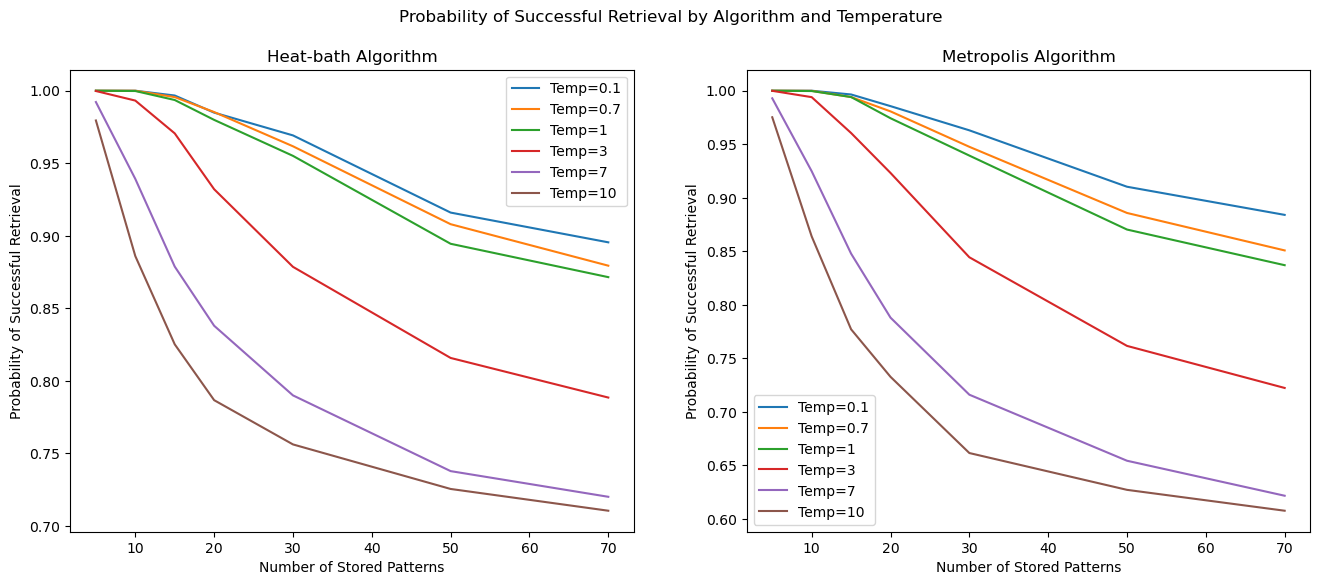

In [4]:
# Initalize results storage
results = {alg: {temp: [] for temp in temperatures} for alg in algorithms}
network = HopfieldNetwork(N)

# Run simulation for various numbers of stored patterns and temperatures
for num_patterns in num_patterns_list:
    patterns = [np.random.choice([-1, 1], size=N) for _ in range(num_patterns)]
    network.store_patterns(patterns)
    for temp in temperatures:
        for alg in algorithms:
            errors = []
            for _ in range(num_trials):
                pattern_index = np.random.randint(num_patterns)
                recalled = network.recall_pattern(patterns[pattern_index], temp, steps, alg)
                error = network.compute_error(patterns[pattern_index])
                errors.append(error)
            success_probability = 1 - np.mean(errors)
            results[alg][temp].append(success_probability)

# Generate plots showinf the probability of sucessful retrieval
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for temp in temperatures:
    axes[0].plot(num_patterns_list, results['heatbath'][temp], label=f'Temp={temp}')
axes[0].set_title('Heat-bath Algorithm')
axes[0].set_xlabel('Number of Stored Patterns')
axes[0].set_ylabel('Probability of Successful Retrieval')
axes[0].legend()

for temp in temperatures:
    axes[1].plot(num_patterns_list, results['metropolis'][temp], label=f'Temp={temp}')
axes[1].set_title('Metropolis Algorithm')
axes[1].set_xlabel('Number of Stored Patterns')
axes[1].set_ylabel('Probability of Successful Retrieval')
axes[1].legend()

plt.suptitle('Probability of Successful Retrieval by Algorithm and Temperature')
plt.show()


The provided plot consists of two subplots, each depicting the probability of successful retrieval of stored patterns in a Hopfield network, as a function of the number of stored patterns. The performance is evaluated using two different algorithms for neuron state updates: the Heat-bath algorithm and the Metropolis algorithm, across various temperatures. 

Oservations for both algorithms: 
At lower temperatures (e.g., 0.1, 0.7, 1), the probability of successful retrieval is higher, indicating better performance.
As the number of stored patterns increases, the retrieval success probability gradually decreases for all temperatures.
Higher temperatures (e.g., 3, 7, 10) show a more pronounced decrease in retrieval success, demonstrating the network's sensitivity to temperature.

## 1.2 High Load and Noisy Patterns

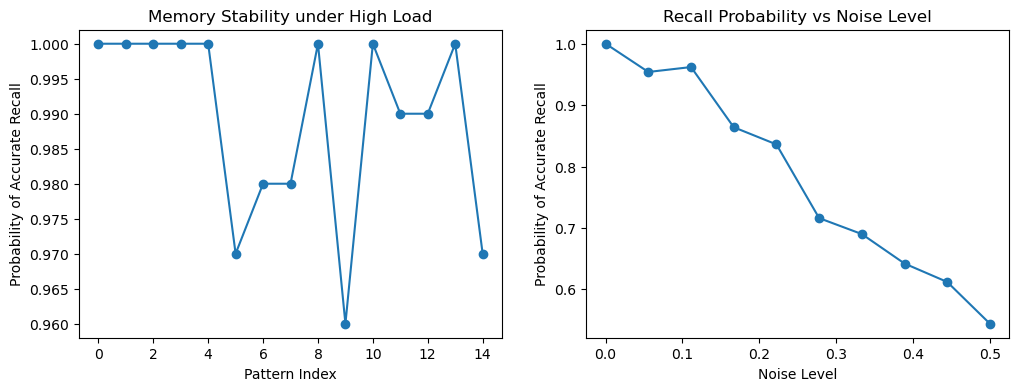

In [5]:
def generate_noisy_pattern(pattern, noise_level):
    noisy_pattern = np.copy(pattern)
    noise = np.random.binomial(1, noise_level, pattern.size)
    noisy_pattern[noise == 1] = 1 - noisy_pattern[noise == 1]
    return noisy_pattern


max_patterns = int(0.15* N)  # Based on theoretical capacity
patterns = [np.random.choice([-1, 1], size=N) for _ in range(max_patterns)]
network.store_patterns(patterns)

# Check stability of each memory under high load
stability_results = []
for pattern in patterns:
    recalled = network.recall_pattern(pattern, temp=1, steps=100, algorithm='heatbath')
    error = network.compute_error(pattern)
    stability_results.append(1 - error)

# Generate noisy recall scenario
noise_levels = np.linspace(0, 0.5, 10)
noisy_recall_results = []
for noise_level in noise_levels:
    errors = []
    for pattern in patterns[:5]:  # Subset of patterns for testing
        noisy_pattern = generate_noisy_pattern(pattern, noise_level)
        recalled = network.recall_pattern(noisy_pattern, temp=1, steps=100, algorithm='heatbath')
        error = network.compute_error(pattern)
        errors.append(error)
    noisy_recall_results.append(1 - np.mean(errors))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(max_patterns), stability_results, marker='o')
plt.title('Memory Stability under High Load')
plt.xlabel('Pattern Index')
plt.ylabel('Probability of Accurate Recall')

plt.subplot(1, 2, 2)
plt.plot(noise_levels, noisy_recall_results, marker='o')
plt.title('Recall Probability vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Probability of Accurate Recall')
plt.show()

Memory Stability under High Load Observations:

The probability of accurate recall is high for most patterns.
Some patterns exhibit slight decreases in recall probability, indicating variability in stability under high load conditions.
The overall trend shows that most patterns are stably recalled, but a few outliers indicate potential instability when the network is heavily loaded.

Recall Probability vs Noise Level Observations:

The recall probability is high when the noise level is low.
As the noise level increases, the recall probability gradually decreases.
There is a drop in recall probability when the noise level exceeds approximately 0.2, highlighting the network's sensitivity to noise.

## 1.3 Capacity Analysis

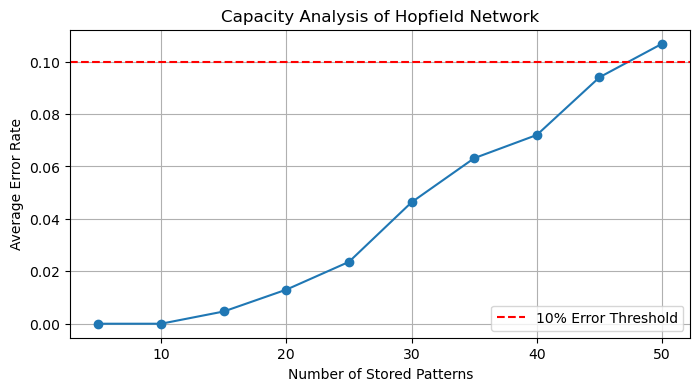

In [6]:
max_patterns_c = int(0.5 * N)  
temp = 1  

network = HopfieldNetwork(N)

error_rates = []
pattern_counts = range(5, max_patterns_c + 1, 5)

for num_patterns in pattern_counts:
    patterns = [np.random.choice([-1, 1], size=N) for _ in range(num_patterns)]
    network.store_patterns(patterns)
    errors = []
    for pattern in patterns:
        recalled = network.recall_pattern(pattern, temp, steps)
        errors.append(network.compute_error(pattern))
    average_error = np.mean(errors)
    error_rates.append(average_error)


plt.figure(figsize=(8, 4))
plt.plot(pattern_counts, error_rates, marker='o')
plt.axhline(y=0.1, color='r', linestyle='--', label='10% Error Threshold')
plt.title('Capacity Analysis of Hopfield Network')
plt.xlabel('Number of Stored Patterns')
plt.ylabel('Average Error Rate')
plt.legend()
plt.grid(True)
plt.show()

The plot shows the average error rate of the Hopfield network as a function of the number of stored patterns, providing insights into the network's capacity.

Observations: 

Initially, with a small number of stored patterns, the error rate is close to zero, indicating perfect recall.
As the number of stored patterns increases, the average error rate gradually increases. This plots confirms that about 0.15 N states can be simultaneously remembered before error in recall is severe which is coherent with the theoretical findings.
The error rate surpasses the 10% threshold when the number of stored patterns reaches around 50, indicating the practical capacity limit of the network.

## 1.4 Error Correction Capability

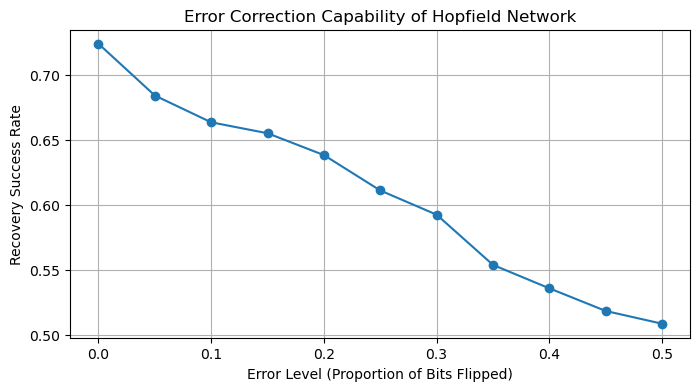

In [7]:
patterns_e = [np.random.choice([-1, 1], size=N) for _ in range(5)]  
network.store_patterns(patterns_e)

error_levels = np.linspace(0, 0.5, 11)  
error_recovery_rates = []

for error_level in error_levels:
    recovery_errors = []
    for pattern in patterns:
        noisy_pattern = generate_noisy_pattern(pattern, error_level)
        recalled_pattern = network.recall_pattern(noisy_pattern, temp=1, steps=100)
        recovery_error = network.compute_error(pattern)
        recovery_errors.append(recovery_error)
    error_recovery_rates.append(1 - np.mean(recovery_errors))  

plt.figure(figsize=(8, 4))
plt.plot(error_levels, error_recovery_rates, marker='o')
plt.title('Error Correction Capability of Hopfield Network')
plt.xlabel('Error Level (Proportion of Bits Flipped)')
plt.ylabel('Recovery Success Rate')
plt.grid(True)
plt.show()

The plot depicts the error correction capability of the Hopfield network, showing the recovery success rate as a function of the error level, defined by the proportion of bits flipped.

Observations: 
At zero error level (no bits flipped), the recovery success rate is above 0.70, indicating very good recall.
As the error level increases, the recovery success rate gradually decreases.
There is a significant drop in the recovery success rate when the error level exceeds approximately 0.3, highlighting the network's decreasing ability to correct high levels of noise.

## 1.5 Generalization from Partial Inputs

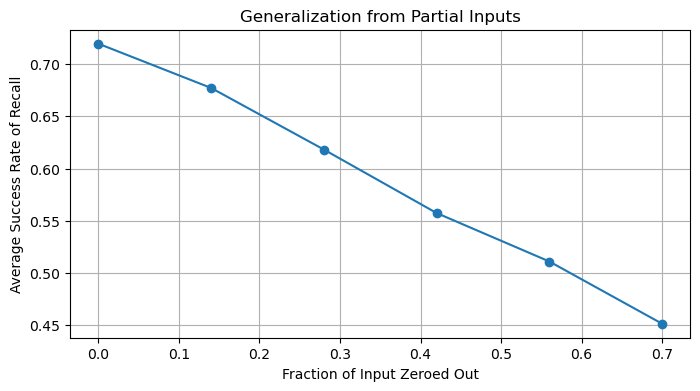

In [8]:
def create_partial_pattern(pattern, fraction):
    # Create a partial pattern by zeroing a fraction of the pattern
    partial_pattern = np.copy(pattern)
    num_zeroed = int(len(pattern) * fraction)
    indices = np.random.choice(range(len(pattern)), num_zeroed, replace=False)
    partial_pattern[indices] = 0 
    return partial_pattern


patterns_g = [np.random.choice([-1, 1], size=N) for _ in range(5)]
network = HopfieldNetwork(N)
network.store_patterns(patterns_g)

fractions = np.linspace(0, 0.7, 6)  
generalization_results = []

for fraction in fractions:
    success_rates = []
    for pattern in patterns:
        partial_pattern = create_partial_pattern(pattern, fraction)
        recalled_pattern = network.recall_pattern(partial_pattern, temp=1)
        error = network.compute_error(pattern)
        success_rates.append(1 - error) 
    generalization_results.append(np.mean(success_rates))

plt.figure(figsize=(8, 4))
plt.plot(fractions, generalization_results, marker='o')
plt.title('Generalization from Partial Inputs')
plt.xlabel('Fraction of Input Zeroed Out')
plt.ylabel('Average Success Rate of Recall')
plt.grid(True)
plt.show()

The plot depicts the network's ability to generalize from partial inputs, showing the average success rate of recall as a function of the fraction of the input pattern zeroed out.


Observations:

With no input zeroed out (fraction = 0), the success rate is above 0.70, indicating very good recall.
As the fraction of the input zeroed out increases, the success rate gradually decreases.
The decline in success rate is approximatively linear, indicating the network's decreasing ability to recall from highly incomplete inputs.

# 2 Discussion of Results and Conclusion

The Hopfield network model, as demonstrated through the simulations, exhibits various strengths and limitations in its associative memory capabilities, error correction, and generalization properties.

The success probability of pattern retrieval in the Hopfield network decreases as the number of stored patterns increases. This is consistent with the theoretical capacity limit of the network. Lower temperatures generally yield higher recall accuracy due to the more deterministic nature of neuron state updates at lower thermal noise levels. The Heat-bath and Metropolis algorithms show similar trends, but with slight variations in retrieval success, indicating algorithm-specific differences in handling neuron state updates.

When the network is heavily loaded with patterns, near its theoretical capacity, it displays varying degrees of stability. Some patterns are recalled perfectly, while others exhibit minor errors. This variability suggests that while the network can maintain stable memory states for a majority of stored patterns, it reaches a limit where additional patterns begin to destabilize the recall process. 


The network's ability to accurately recall stored patterns decreases as the noise level in the input increases. This trend highlights the network's sensitivity to input distortions. At low noise levels, the network effectively recalls patterns, but as the noise level increases, the probability of successful recall diminishes significantly.


The capacity analysis indicates that as the number of stored patterns increases, the average error rate in recall also increases. The network maintains low error rates up to a certain point, after which the error rate rises sharply. This behavior is in line with the theoretical capacity limit of the network, approximately 0.15 times the number of neurons (N). Beyond this limit, the network struggles to maintain accurate recall of stored patterns.


The Hopfield network demonstrates robust error correction capabilities at lower noise levels, successfully recalling the original patterns even when a significant portion of the input is corrupted. However, the success rate decreases as the noise level increases, indicating the network's limitation in handling high noise levels.


The network shows the ability to generalize from partial inputs, recalling the correct pattern even when a significant fraction of the input is missing. The success rate decreases as more of the input is zeroed out, but the network performs reasonably well for moderate levels of input incompleteness. This property is crucial for practical applications where complete inputs may not always be available.

#### Relevance to Hopfield's 1982 Paper

The results from these simulations are coherent with the findings presented in Hopfield's 1982 paper. The paper discusses the information storage capacity, error correction, and stability of memory states, all of which are reflected in the simulation outcomes. Specifically, the observed capacity limit, error correction performance, and the effects of thermal noise on retrieval accuracy align with Hopfield's theoretical framework.

#### Additional Insights

One interesting observation from the simulations is the difference in performance between the Heat-bath and Metropolis algorithms. While both algorithms generally follow the same trends, the Heat-bath algorithm appears to perform slightly better at higher temperatures. This could suggest that for applications where thermal noise is a significant factor, the choice of the algorithm could slightly impact the overall performance of the network.

Moreover, the ability of the Hopfield network to generalize from partial inputs demonstrates its potential for use in scenarios where data may be incomplete or partially corrupted. This highlights the network's robustness and adaptability, making it a valuable tool in fields such as image recognition and associative memory tasks where perfect input conditions cannot always be guaranteed.

#### Conclusion

In conclusion, the Hopfield network simulations provide empirical evidence supporting the theoretical predictions of associative memory systems in neural networks. The network's capacity limits, error correction capabilities, and generalization properties underscore its practical utility and inherent limitations, offering valuable insights for applications and developments in neural network models.